<a href="https://colab.research.google.com/github/ahlexn/DATA3402.Spring.2024/blob/main/Copy_of_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OVERVIEW:**
This challenge was to predict whether patients that were diagnosed with breast cancer would receive a metastatic cancer disgnosis within 90 days of their screening. The approach was determined by looking at when the diagnosis happened and when treatment started. Using classification and comparing the classes to one another only let my predictor model be aroun 50%.

In [ ]:
#cell used to import data from kaggle
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'metastatic-cancer-kaggle-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4928092%2F8296270%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T032155Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D79d9e4119a9a978c16c09eeeb911e0f949da05c2cb94423b04fa178e4461cdeafec6110e4c0adac61b27a1ac0c0e8dc1ae661b3594a52d7162022a563bcdec9459739f1bcb6360bc4b810f75db8fca53813b3f2b10a9bede089128d14c49ed6cf63e9dd4007e9063aab345c6c904dc35fdbc0e169a2bcf1d1d8c216df35dd18e6d72947de9d7735579f5a7be6066d7ecbf0df34c83d8bc4a95a632184c7dae4a81882ce2ffb09f713080a87aae58443a1f60005a2d3b84e26a683581af6415ae5499d68d3f3e57159e913754e4d5a9584069babe61896bf839e3b13bf5775c1bb4f891e57f991adf42e2f23c7839b026a613d945828f3436f8d6a5798e6540ca'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5281541 bytes downloaded
Downloaded and uncompressed: metastatic-cancer-kaggle-challenge
Data source import complete.


In [ ]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/metastatic-cancer-kaggle-challenge/training.csv
/kaggle/input/metastatic-cancer-kaggle-challenge/sample_submission.csv
/kaggle/input/metastatic-cancer-kaggle-challenge/test.csv


In [ ]:
#importing needed packages
import math
import matplotlib.pyplot as plt
import seaborn as sns
import shap as shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 300)

In [ ]:
#loading up training and testing data sets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df_train = pd.read_csv("/kaggle/input/metastatic-cancer-kaggle-challenge/training.csv", sep=',')
df_test = pd.read_csv("/kaggle/input/metastatic-cancer-kaggle-challenge/test.csv", sep=',')

/kaggle/input/metastatic-cancer-kaggle-challenge/training.csv
/kaggle/input/metastatic-cancer-kaggle-challenge/sample_submission.csv
/kaggle/input/metastatic-cancer-kaggle-challenge/test.csv


In [ ]:
# Check the number of rows and columns
print("Number of train samples are",df_train.shape)
print("Number of test samples are",df_test.shape)

Number of train samples are (12906, 83)
Number of test samples are (5792, 82)


In [ ]:
df_train["DiagPeriodL90D"].unique()

array([1, 0])

In [ ]:
df_train.dtypes

patient_id                                 int64
patient_race                              object
payer_type                                object
patient_state                             object
patient_zip3                               int64
patient_age                                int64
patient_gender                            object
bmi                                      float64
breast_cancer_diagnosis_code              object
breast_cancer_diagnosis_desc              object
metastatic_cancer_diagnosis_code          object
metastatic_first_novel_treatment          object
metastatic_first_novel_treatment_type     object
Region                                    object
Division                                  object
population                               float64
density                                  float64
age_median                               float64
age_under_10                             float64
age_10_to_19                             float64
age_20s             

In [ ]:
categorical_features = df_train.select_dtypes('object').columns
# visualize_features = ['State_Factor', 'building_class', 'facility_type', 'Year_Factor']
numerical_features= df_train.select_dtypes('number').columns

In [ ]:
categorical_features

Index(['patient_race', 'payer_type', 'patient_state', 'patient_gender',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division'],
      dtype='object')

interactive(children=(Dropdown(description='Categorical Variable:', options=('patient_race', 'payer_type', 'pa…

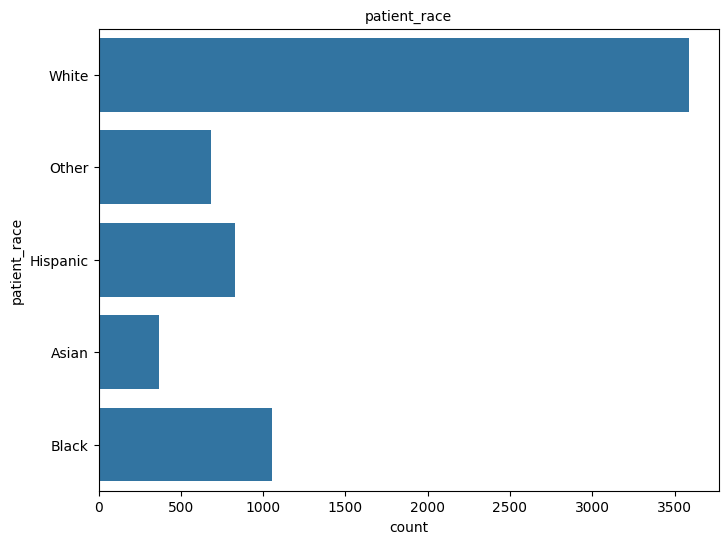

In [ ]:
plot_cat_dataframe = df_train #test

#hist plot categorical features
def count_plot(var, plot_cat_dataframe):
    plt.figure(figsize = (8,6))
    ax = sns.countplot(y = var, data = plot_cat_dataframe)
    plt.title(var, size = 10)

def inter_cat_plot(x):
    return count_plot(x, plot_cat_dataframe)

#Multiple selection widgets ###
widget_cat_plot=widgets.Dropdown(
    options=categorical_features,
# value='State_Factor',
    description="Categorical Variable:",
    style = style
)
interact(inter_cat_plot, x=widget_cat_plot);

interactive(children=(Dropdown(description='Numerical Variable:', options=('patient_id', 'patient_zip3', 'pati…

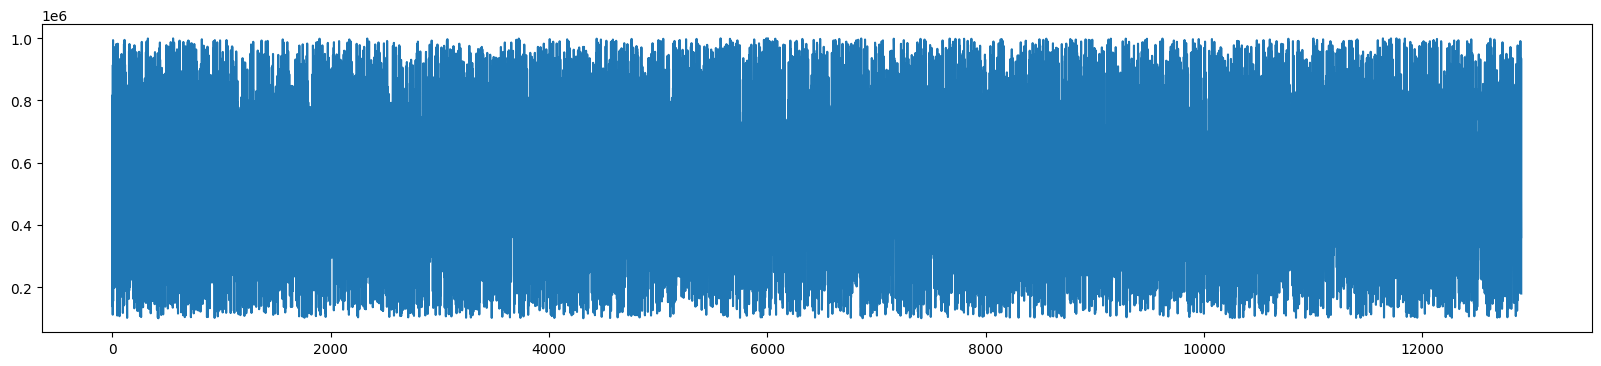

In [ ]:
plot_num_data = df_train[numerical_features]

# plot_num_data = train[train['State_Factor']=='State_1']

# data_state_1 = train[train['State_Factor']=='State_2']
# plot_num_data = data_state_1[data_state_1['building_class']=='Commercial']


#Trend line plot ###
def line_plot(var, plot_num_data):
    plt.figure(figsize = (20,4))
    plot_num_data[var].plot(figsize=(20,4));

def inter_cat_plot(x):
    return line_plot(x, plot_num_data)

# Multiple selection widgets ###
widget_cat_plot=widgets.Dropdown(
    options=plot_num_data.select_dtypes('number').columns,
#     value="january_avg_temp",
    description="Numerical Variable:",
    style = style
)
interact(inter_cat_plot, x=widget_cat_plot);

In [ ]:
#Distribution plot
def dist_plot(feature_list, train, test):
    for each_feature in feature_list:
        plt.figure(figsize = (20, 4))

        sns.kdeplot(train[each_feature].to_numpy(), color = '#5499C7') # blue training data
        sns.kdeplot(test[each_feature].to_numpy(), color = '#D35400') # red testing data

        plt.title(each_feature, fontsize=15)
        plt.show()

#del values_train , values_test

def inter_dist_plot(x):
    return dist_plot(x, df_train, df_test)

#Multiple selection widgets
widget_dist_plot=widgets.SelectMultiple(
    options= df_train.select_dtypes('number').columns,
#value=["floor_area"],
    layout=Layout(width='50%', height='200px'),
    description="Numerical Variable:",
    style = style
)
interact(inter_dist_plot, x=widget_dist_plot);

interactive(children=(SelectMultiple(description='Numerical Variable:', layout=Layout(height='200px', width='5…

<Axes: >

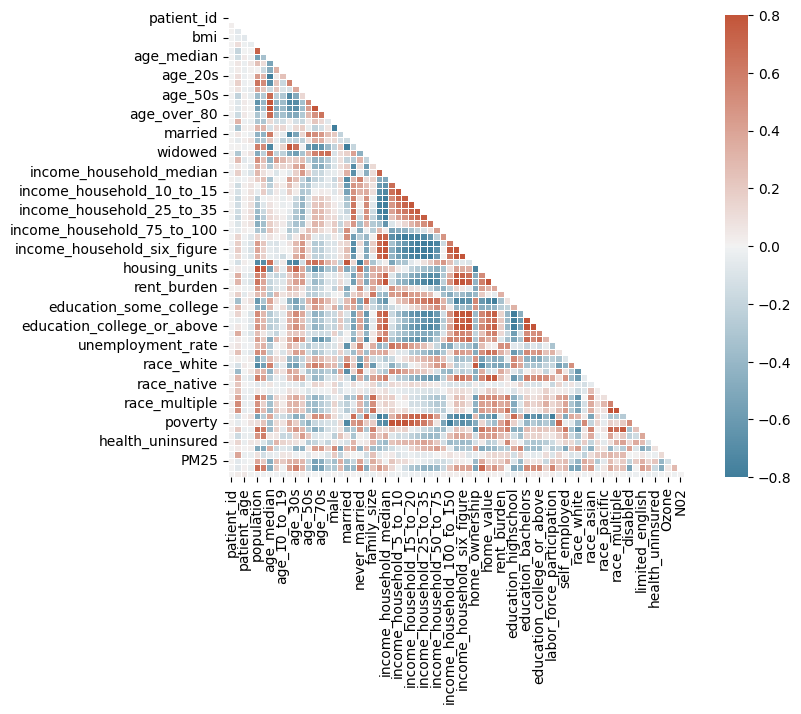

In [ ]:
# Calculate correlation matrix
# Check parameters: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
corr = df_train[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.8,vmax=0.8, square=True, linewidths=.5)

**DATA CLEANING:**
  Deleting duplicates and missing values as that can affect how data is presented and the quality of data representations. Duplicates can be removed using the panda notebook, Followed by checking for missing values will affect machine learning as well. Using check_missing_values() to analyze missing values in a pandas DataFrame we can check for (NaN), missing values, and summarize the missing data.

In [ ]:
num_duplicates = df_train.duplicated().sum()

print("Number of duplicate rows: ", num_duplicates)

Number of duplicate rows:  0


In [ ]:
def check_missing_values(df):
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    missingvalues_count =df.isna().sum()
    missingValues_df = pd.DataFrame(missingvalues_count.rename('Missing Values')).loc[missingvalues_count.ne(0)]
    missingValues_df['Percentage'] = missingValues_df['Missing Values'] * 100 / df.shape[0]
    return missingValues_df

In [ ]:
df = check_missing_values(df_train)
print(df.sort_values(by='Missing Values', ascending=False))

                                       Missing Values  Percentage
metastatic_first_novel_treatment                12882   99.814040
metastatic_first_novel_treatment_type           12882   99.814040
bmi                                              8965   69.463815
patient_race                                     6385   49.473113
payer_type                                       1803   13.970246
Region                                             52    0.402913
Division                                           52    0.402913
patient_state                                      51    0.395165
PM25                                               29    0.224702
Ozone                                              29    0.224702
N02                                                29    0.224702
income_household_75_to_100                          4    0.030993
income_household_150_over                           4    0.030993
income_household_15_to_20                           4    0.030993
income_hou

In [ ]:
print("No. of records before dropping missing values : ",df_train.shape[0])
df_dropall_missing_values = df_train.dropna()
print("No. of records after dropping missing values : ",df_dropall_missing_values.shape[0])

No. of records before dropping missing values :  12906
No. of records after dropping missing values :  3


In [ ]:
df_train_dropped_columns = df_train.drop(columns=df_train.columns[df_train.isnull().mean() > 0.3])

print("No. of columns before dropping: ", df_train.shape[1] )
print("No. of columns after dropping: ", df_train_dropped_columns.shape[1] )
print(df_train.shape[1]- df_train_dropped_columns.shape[1]," columns dropped")

# Identify which columns were dropped
dropped_columns = df_train.columns.difference(df_train_dropped_columns.columns)
print(dropped_columns)

No. of columns before dropping:  83
No. of columns after dropping:  79
4  columns dropped
Index(['bmi', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'patient_race'],
      dtype='object')


In [ ]:
check_missing_values(df_train_dropped_columns)

,Missing Values,Percentage
payer_type,1803,13.970246
patient_state,51,0.395165
Region,52,0.402913
Division,52,0.402913
population,1,0.007748
density,1,0.007748
age_median,1,0.007748
age_under_10,1,0.007748
age_10_to_19,1,0.007748
age_20s,1,0.007748


In [ ]:
df_dropped_missing_values = df_train_dropped_columns.dropna()

print("No. of records before dropping missing values : ",df_train_dropped_columns.shape[0])
print("No. of records after dropping missing values : ",df_dropped_missing_values.shape[0])

No. of records before dropping missing values :  12906
No. of records after dropping missing values :  11043


In [ ]:
df_train = df_dropped_missing_values.copy()

In [ ]:
# Drop the same columns from test set
df_test = df_test.drop(columns=dropped_columns)
#Drop rest of the missing values in test set
df_test.dropna(inplace=True)

In [ ]:
#Check the shapes of train and test set
print("Train set shape: ",df_train.shape)
print("Test set shape: ",df_test.shape)

Train set shape:  (11043, 79)
Test set shape:  (4999, 78)


No. of instances per class
DiagPeriodL90D
1    6753
0    4290
Name: count, dtype: int64


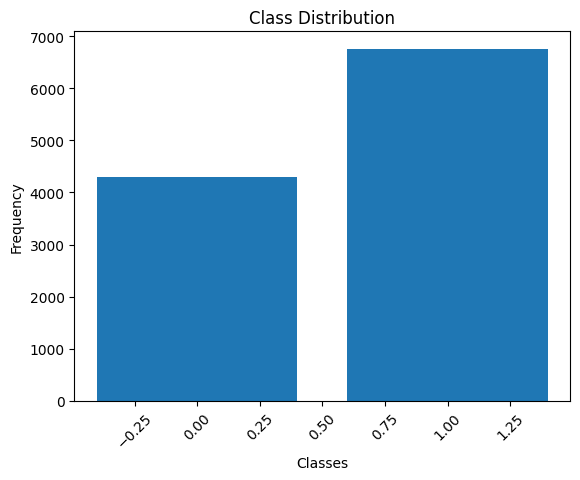

In [ ]:
#check for imbalace classes
import pandas as pd
import matplotlib.pyplot as plt

def check_class_distribution(df):

    # Count the number of classes
    class_counts = df["DiagPeriodL90D"].value_counts()

    # Display the number of instances per class
    print("No. of instances per class")
    print(class_counts)

    # Plotting the bar graph for class distribution
    plt.bar(class_counts.index, class_counts.values)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()


check_class_distribution(df_train)

In [ ]:
from sklearn.utils import resample

# Separate the majority and minority classes
majority_class = df_train[df_train['DiagPeriodL90D'] == 1]
minority_class = df_train[df_train['DiagPeriodL90D'] == 0]

# Randomly undersample the majority class to match the minority class size
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

# Combine the downsampled majority class with the minority class
balanced_df = pd.concat([majority_downsampled, minority_class])

# Shuffle the rows in the balanced DataFrame to mix the classes
balanced_df = balanced_df.sample(frac=1, random_state=42)

df_train = balanced_df.copy()

No. of instances per class
DiagPeriodL90D
0    4290
1    4290
Name: count, dtype: int64


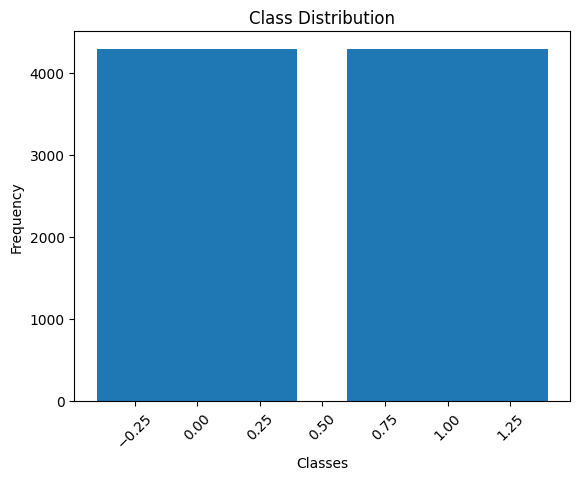

In [ ]:
check_class_distribution(df_train)

**CATEGORICAL VARIABLES:**
Converting categorical variables to numerical values for machine learning

In [ ]:
categorical_cols = df_train.select_dtypes(include=['object', 'category']).columns

le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])

**TRAINING:**
Logistic Regression was used

In [ ]:
#seperate train into training features and target
X = df_train.drop('DiagPeriodL90D', axis=1)
y = df_train['DiagPeriodL90D']

In [ ]:
#splitting the training set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#fitting the model
from sklearn.linear_model import LogisticRegression

# Initialize the classifier
log_reg = LogisticRegression(max_iter=1000, solver='sag')

# Train the classifier
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='sag')

In [ ]:
from sklearn.model_selection import cross_val_score
#Perform 5-fold cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.51857247 0.52367079 0.50764749 0.53095412 0.49125364]
Mean cross-validation score: 0.5144197019146854


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test set
y_pred = log_reg.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
confusion = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.5081585081585082
Precision: 0.5052770448548812
Recall: 0.4495305164319249
F1 Score: 0.4757763975155279
Confusion Matrix:
 [[489 375]
 [469 383]]


In [ ]:
#predict on our final test set
predictions = log_reg.predict_proba(df_test)
predictions = predictions[:,1]

In [ ]:
submission_df = pd.DataFrame({
    'patient_id': df_test['patient_id'],
    'DiagPeriodL90D': predictions
})
submission_df.head()

,patient_id,DiagPeriodL90D
0,573710,0.493498
1,593679,0.508171
2,184532,0.500074
3,447383,0.494867
5,281312,0.490093
